# Synchronization of Logistic Map Orbits
August 26, 2016

Author: W. L. Maier

This notebook explores synchronization in an array of coupled logistic maps. The logistic map is the iterative map defined by

$$x_{n+1} = r \hspace{1 pt} x_n (1 - x_n)$$

where $x_n$ has a value in the range $(0,1)$ and $r$ is a parameter.

In [1]:
using PyPlot;

  likely near /home/bmaier/.julia/v0.5/IJulia/src/kernel.jl:35
  likely near /home/bmaier/.julia/v0.5/IJulia/src/kernel.jl:35
  likely near /home/bmaier/.julia/v0.5/IJulia/src/kernel.jl:35


We'd like to explore synchronization among a set of $N$ logistic maps. To do this we have to define a way for the maps to interact with each other, and there are a number of possibilities for doing this. For this example we will form an array of logistic maps indexed from $1$ to $N$, and we will couple the map at index $i$ to the adjacent map at index $i+1$. We wrap the array around so that the map at index $N$ couples to the map at index $1$. We also define a coupling parameter $\epsilon$ with $0 \le \epsilon \le 1$ so we can vary the amount of feedback between adjacent maps. The equation for the $i^{th}$ map is then

$$x_{k+1} = \epsilon [r \hspace{1 pt} x_k\ (1-x_k)]_i + (1-\epsilon)[r \hspace{1 pt} x_k\ (1-x_k)]_{i+1}.$$

The state of the system is specified by giving the $x$ value for each map in the array at a given time. Let's define a composite type to hold this information. We don't really have to do this because it is simply an array of floating point numbers $\{x_k:k \in [1:N]\}$, but it is handy to have a name for a system state to distinguish it from a plain array of numbers.

In [2]:
type SystemState
    maps::Array{Float64,1}
end

Now we can define the iteration function for a specific map in the array.

In [3]:
function logistic(state::SystemState, i, r, ϵ)
    xi = state.maps[i]
    if i == length(state.maps)
        xi1 = state.maps[1]
    else
        xi1 = state.maps[i+1]
    end
    return (1-ϵ) * (r*xi*(1.0-xi)) + ϵ*(r*xi1*(1.0-xi1))
end

logistic (generic function with 1 method)

Create a function to iterate the state forward one step.

In [4]:
function iterate(state0::SystemState, r, ϵ)
    N = length(state0.maps)
    state1 = SystemState(zeros(N))
    for i in 1:N
        state1.maps[i] = logistic(state0, i, r, ϵ)
    end
    return state1
end

iterate (generic function with 1 method)

Let's create a system and initialize the maps to random values.

In [5]:
N=8;

In [6]:
state0 = SystemState(rand(N));

Now we can iterate the system. We'll create a list of states to keep track of the states as the system evolves.

In [7]:
allstates = [state0];

In [8]:
r = 3.8; ϵ = 0.0;

In [9]:
for j in 1:5
    newstate = iterate(allstates[end], r, ϵ)
    push!(allstates, newstate)
end;

In [10]:
allstates

6-element Array{SystemState,1}:
 SystemState([0.613978,0.27921,0.145261,0.967818,0.348006,0.870059,0.609505,0.65712])  
 SystemState([0.900634,0.764757,0.471808,0.118355,0.862212,0.429613,0.904433,0.85619]) 
 SystemState([0.34007,0.683634,0.94698,0.39652,0.451449,0.931174,0.32845,0.467889])    
 SystemState([0.852805,0.821858,0.190795,0.909309,0.941043,0.243539,0.838169,0.946082])
 SystemState([0.477009,0.556349,0.58669,0.313371,0.21083,0.700066,0.515439,0.193842])  
 SystemState([0.947991,0.937934,0.921442,0.817644,0.632246,0.7979,0.949094,0.593817])  

Looking at the sample output above we can feel reasonably confident we have a working system. Now let's ramp up the number of maps and run it for more steps.

In [11]:
N=200; nsteps=300;

In [12]:
state0 = SystemState(rand(N));

In [13]:
allstates = [state0];

In [14]:
r = 3.8; ϵ = 0.0;

In [15]:
for j in 1:nsteps
    newstate = iterate(allstates[end], r, ϵ)
    push!(allstates, newstate)
end;

For larger systems in can be helpful to view the results graphically. We'll make an image with $N$ pixels in the $x$ direction and $\textit{nsteps}$ pixels in the $y$ direction. The color of a pixel will indicate the map value at that index for that step. The image data will be UInt8 values, so we must convert the map values in the range $[0.0, 1.0]$ to values in $[0,255]$.

In [16]:
imgdata = zeros(UInt8, (nsteps,N));

In [17]:
for i in 1:N
    for j in 1:nsteps
        tmp = round(256*allstates[j].maps[i])
        if tmp >= 256.0
            tmp = 255.0
        elseif tmp < 0.0
            tmp = 0.0
        end
        imgdata[j,i] = UInt8(tmp)
    end
end;

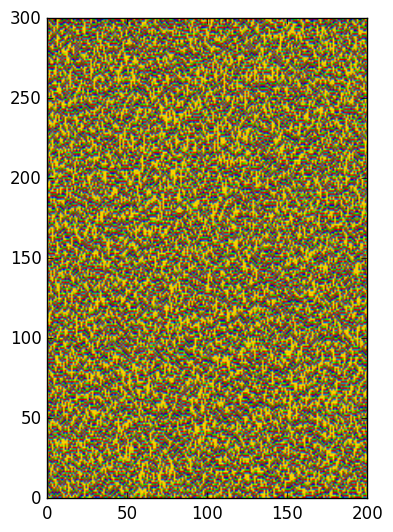

  likely near /home/bmaier/.julia/v0.5/IJulia/src/kernel.jl:35
in show at /home/bmaier/.julia/v0.6/PyPlot/src/PyPlot.jl


In [18]:
imshow(imgdata, cmap="nipy_spectral", extent=[0, N, 0, nsteps]);

In order to quickly change parameters and draw the resulting image, it is useful to have a function which encapsulates this.

In [19]:
function states_to_image(allstates)
    nsteps = length(allstates)
    N = length(allstates[1].maps)
    imgdata = zeros(UInt8, (nsteps,N));
    for i in 1:N
        for j in 1:nsteps
            tmp = round(256*allstates[j].maps[i])
            if tmp >= 256.0
                tmp = 255.0
            elseif tmp < 0.0
                tmp = 0.0
            end
            imgdata[j,i] = UInt8(tmp)
        end
    end
    return imgdata
end;

In [20]:
function drawsys(N, nsteps, r, ϵ)
    allstates = [SystemState(rand(N))];
    for j in 1:nsteps
        newstate = iterate(allstates[end], r, ϵ)
        push!(allstates, newstate)
    end;
    imgdata = states_to_image(allstates);
    imshow(imgdata, cmap="nipy_spectral", extent=[0, N, nsteps, 0]);
    return imgdata
end;

Now we can set parameters, run the simulation, and display the image all on a single line.

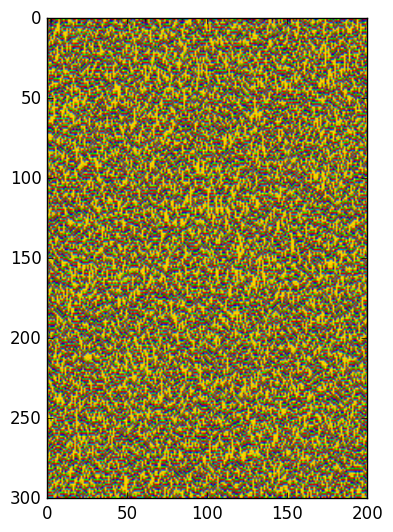

In [21]:
N = 200; nsteps = 300; r = 3.8; ϵ = 0.0; img = drawsys(N, nsteps, r, ϵ);

The simulation above is for no coupling, so the individual maps are completely independent. Let's try this again but with a relatively high value for the coupling constant $\epsilon$.

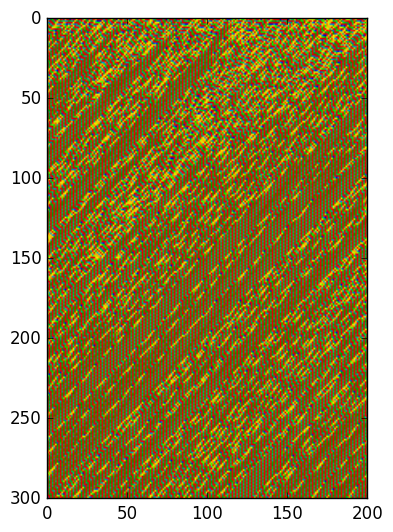

In [22]:
N = 200; nsteps = 300; r = 3.8; ϵ = 0.9; img = drawsys(N, nsteps, r, ϵ);

Comparing the two images above, you can see at a glance that the second system is tending toward synchronization over time.